# Optimization for Collabrative filtering

## Imports

In [25]:
import numpy as np
import pandas as pd
import lenskit.crossfold as xf
import matplotlib.pyplot as plt
from lenskit.algorithms.bias import Bias
from lenskit.batch import predict
import lenskit
from functions import *

# A. Preprocessing of data

1. Data format

We are going to preprocess a rating file in the following csv format:  
```
UserID::MovieID::Rating::Timestamp
```

2. Prepare data for cross-validation

Splitting Data for a user-based N-fold cross-validation. Store each partition into a new csv file. 

It is convinient to use a python package lenskit. It can be installed by following https://lkpy.readthedocs.io/en/stable/install.html

Use the function lenskit.crossfold.partition_rows to partition all the ratings into N train-test partitions.

3. Convert to a list format

Convert data into a list format for fast processing


In [5]:
# read a DataFrame of ratings from the csv ratings file
csvroot = 'data' 
ratings = pd.read_csv(csvroot + '/ratings.csv')
ratings = ratings.rename(columns={'userId': 'user', 'movieId': 'item'})

lst_users, dic_users = unique(ratings['user'])
lst_items, dic_items = unique(ratings['item'])
M = len(lst_users)
N = len(lst_items)

matrixSparsity = len(ratings) / (M*N)
print("We have %d users, %d movies and the %d ratings matrix has %f percent of non-zero value.\n" % (M, N,ratings.shape[0],100*matrixSparsity))

We have 610 users, 9724 movies and the 100836 ratings matrix has 1.699968 percent of non-zero value.



In [6]:
# 2 fold cross-validation, store each partition (both train and test) in a seperate csv file.
# Point 1: report the number of (user,iter,rating) items in each file.
df = ratings

# Create 2 folds using partition_rows
folds = xf.partition_rows(df, 5)

# Iterate over the folds and write each partition to a separate CSV file
for i, (train, test) in enumerate(folds):
    
    train = train.rename(columns={'userId': 'user', 'movieId': 'item'})
    test = test.rename(columns={'userId': 'user', 'movieId': 'item'})

    train.to_csv(f'data/train_{i}.csv', index=False)
    test.to_csv(f'data/test_{i}.csv', index=False)
    

    # Print the number of (user, item, rating) items in each partition
    print(f'fold {i}')


    lst_users, dic_users = unique(train['user'])
    lst_items, dic_items = unique(train['item'])
    Ml = len(lst_users)
    Nl = len(lst_items)
    matrixSparsity = len(ratings) / (M*N)
    print("We have %d users, %d movies and %d rating \n" % (Ml, Nl,train.shape[0]))


    lst_users, dic_users = unique(test['user'])
    lst_items, dic_items = unique(test['item'])
    Ml = len(lst_users)
    Nl = len(lst_items)

    print("We have %d users, %d movies and %d rating \n" % (Ml, Nl,test.shape[0]))
    



fold 0
We have 610 users, 8972 movies and 80668 rating 

We have 610 users, 5077 movies and 20168 rating 

fold 1
We have 610 users, 8973 movies and 80669 rating 

We have 610 users, 5155 movies and 20167 rating 

fold 2
We have 610 users, 8946 movies and 80669 rating 

We have 610 users, 5152 movies and 20167 rating 

fold 3
We have 610 users, 9026 movies and 80669 rating 

We have 610 users, 5013 movies and 20167 rating 

fold 4
We have 610 users, 8956 movies and 80669 rating 

We have 610 users, 5155 movies and 20167 rating 



In [7]:
# read the csv files from a partition of the cross-validation
# convert them to RDD using convert_DF_to_RDD

# Read the train and test sets for a specific fold 0 from CSV files
train_0_df = pd.read_csv(csvroot+ '/train_0.csv')
test_0_df = pd.read_csv(csvroot+ '/test_0.csv')

# Convert the train and test sets to RDDs using convert_DF_to_RDD
train_0_rdd = convert_DF_to_RDD(train_0_df)
test_0_rdd = convert_DF_to_RDD(test_0_df)


# Read the train and test sets for a specific fold 1 from CSV files
train_1_df = pd.read_csv(csvroot+ '/train_1.csv')
test_1_df = pd.read_csv(csvroot+ '/test_1.csv')

# Convert the train and test sets to RDDs using convert_DF_to_RDD
train_1_rdd = convert_DF_to_RDD(train_1_df)
test_1_rdd = convert_DF_to_RDD(test_1_df)


# B. Gradient-descent algorithm

Based on the preprocessing, we are going to develop a method to find optimal P and Q on training data. It contains: 

1. compute the objective and the gradient of the objective function
2. implement the gradient-descent algroithm
3. measure the speed of this method

In [8]:
# use a random P and Q to test the function computeMSE
# Point 2: report MSE with LAMBDA=0
K = 14 # rank parameter (best chose)
P = np.random.rand(M,K) # user's features matrix (M by K)
Q = np.random.rand(N,K) # item's features matrix (N by K)

ratings_rdd = convert_DF_to_RDD(ratings)
print('MSE =',  computeMSE(ratings_rdd,P,Q))

MSE = 1.8414351259155368


In [9]:

# Compare GD constant step size with GD line search step size
# Point 3: Make plots to show how (regularized) MSE changes with respect to GD iterations 
# Mention your initialization of P,Q, and the stopping criterion of GD

### TODO


def run_gd(RDD, M, N, K, MAXITER , GAMMA, LAMBDA, adaptive):
    # Run the gradient descent algorithm
    P, Q, lreg_mse, lmse = GD(RDD, M, N, K, MAXITER, GAMMA, LAMBDA, adaptive)
    # Plot the MSE at each iteration
    plt.plot(range(MAXITER), lmse,'*', label='MSE')
    plt.plot(range(MAXITER), lreg_mse, label='Regularized MSE')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.title(f'adaptive={adaptive}')
    plt.legend()
    plt.show()
    return P,Q 
# Set the hyperparameters
MAXITER = 10
GAMMA = 0.1
LAMBDA = 0.001

RDD =ratings_rdd

# Run the gradient descent algorithm with a constant step size
P, Q = run_gd(RDD, M, N, K, MAXITER, GAMMA, LAMBDA, adaptive=0)




mse : 1.683442892445045
reg_mse : 1.683442892445045
1


KeyboardInterrupt: 

mse : 6.210914268702801
reg_mse : 6.210914268702801
1
mse : 6.197403754970032
reg_mse : 6.197403754970032
2
mse : 6.183957742919508
reg_mse : 6.183957742919508
3
mse : 6.170575695646213
reg_mse : 6.170575695646213
4
mse : 6.157257082124784
reg_mse : 6.157257082124784
5
mse : 6.144001377138007
reg_mse : 6.144001377138007
6
mse : 6.1308080612067135
reg_mse : 6.1308080612067135
7
mse : 6.117676620521445
reg_mse : 6.117676620521445
8
mse : 6.104606546873942
reg_mse : 6.104606546873942
9
mse : 6.091597337590305
reg_mse : 6.091597337590305
10
mse : 6.078648495464745
reg_mse : 6.078648495464745
11
mse : 6.065759528693858
reg_mse : 6.065759528693858
12
mse : 6.052929950811834
reg_mse : 6.052929950811834
13
mse : 6.040159280627351
reg_mse : 6.040159280627351
14
mse : 6.027447042159523
reg_mse : 6.027447042159523
15
mse : 6.0147927645765895
reg_mse : 6.0147927645765895
16
mse : 6.002195982133801
reg_mse : 6.002195982133801
17
mse : 5.9896562341134985
reg_mse : 5.9896562341134985
18
mse : 5.97717

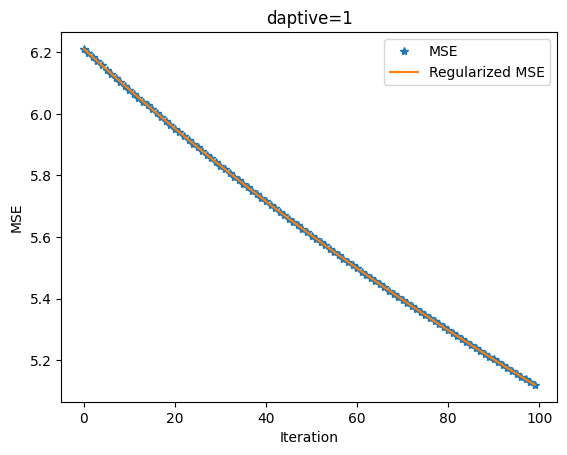

In [46]:
# Run the gradient descent algorithm with a line search step size
P1, Q1 = run_gd(RDD, M, N, K, MAXITER, GAMMA, LAMBDA, adaptive=1)

# C. Perofomance evaluation
1. Compute RMSE score. You should use lenskit.metrics.predict.rmse for a fair comparison. Analyze both the training and test score on the 5 cross-validation partitions. 
2. Compare with a baseline method called Bias. Tune the hyper-parameters such as K and lambda to see if you can obtain a smaller RMSE. Try to explain why. 


In [21]:
# Point 4: Report RMSE, together with your choice of K,LAMBDA and GD parameters
def evaluate_rmse(RDD, P, Q):
    """ 
    This function computes the root MSE score on the rating of RDD. It compares the rating of each (i,j)
    in RDD, with the prediction made by <p_i,q_j>. 
    Args:
        RDD: a dict of list of users, items, ratings
        P: optimal P found by GD
        Q: optimal Q found by GD
    Returns:
        RMSE: the RMSE score
    """
    
    # Get the lists of users, items, and ratings from the RDD
    users = RDD['users']
    items = RDD['items']
    ratings = RDD['ratings']
    unique_items, items_dict = unique(items)
    users_items, users_dict = unique(users)
    
    # Initialize a list to store the predicted ratings
    preds = []
    
    # Loop through the ratings
    for idx in range(len(ratings)):
        # Get the user ID and item ID for the current rating
        user_id = users_dict[users[idx]]
        item_id = items_dict[items[idx]]
        p = P[user_id]
        q = Q[item_id]
        
        # Compute the predicted rating using the dot product of P and Q
        rating = np.dot(p,q)
        
        # Append the predicted rating to the list
        preds.append(rating)
    
    # Compute the RMSE score
    rmse_score = lenskit.metrics.predict.rmse(ratings,preds)
    return rmse_score


In [22]:
# Compare the performance with a baseline method called Bias
    # see in https://lkpy.readthedocs.io/en/stable/bias.html
    # Point 5:  report the RMSE of the baseline method, and analyze the results
    # Hint: use read_csv in panda to read you csv data
def train_and_evaluate_bias(train_df, test_df) :
    # Train the Bias model on the training data
    model = Bias()
    model.fit(train_df)

    # Make predictions on the test data
    predictions = predict(model, test_df)
    predictions_train = predict(model, train_df)

    # Calculate the RMSE of the predictions
    test_train = np.sqrt(lenskit.metrics.predict.rmse(predictions_train.rating, train_df.rating))
    test_bias = np.sqrt(lenskit.metrics.predict.rmse(predictions.rating, test_df.rating))
    return test_train, test_bias

In [23]:
MAXITER = 10
GAMMA = 0.1
LAMBDA = 0.001
K = 14

Processing fold 0
mse : 1.777721622718001
reg_mse : 1.777721622718001
1
mse : 1.7732562688342326
reg_mse : 1.7732562688412792
2
mse : 1.7688571979321226
reg_mse : 1.7688571979603085
3
mse : 1.7645228521830747
reg_mse : 1.7645228522462222
4
mse : 1.7602517186655093
reg_mse : 1.7602517187771693
5
mse : 1.756042327924655
reg_mse : 1.75604232809825
6
mse : 1.7518932525812942
reg_mse : 1.75189325282969
7
mse : 1.7478031059877632
reg_mse : 1.7478031063235628
8
mse : 1.7437705409296635
reg_mse : 1.7437705413653413
9
mse : 1.7397942483720539
reg_mse : 1.7397942489198102
10


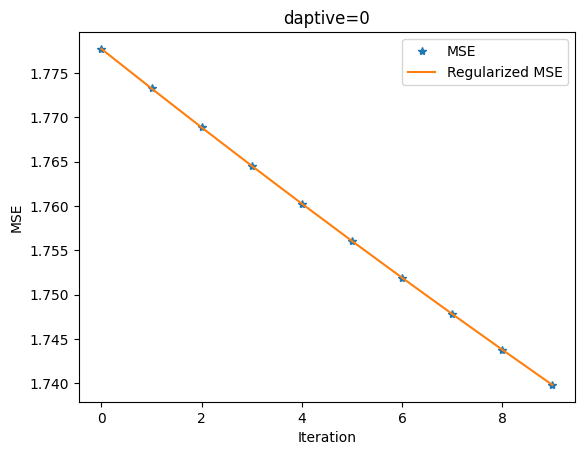

Training RMSE for fold 0: 1.3058156513318913
Test RMSE for fold 0: 1.3022744090581002
Training RMSE for Bias model on fold 0: 0.0
Test RMSE for Bias model on fold 0:        user   item  rating
0        68   4621     3.5
1       480     95     1.0
2       474   4160     4.5
3       125  71304     4.5
4        21    597     4.0
...     ...    ...     ...
20163   318   6440     3.5
20164    47  49824     2.5
20165   520   7036     5.0
20166   177   2078     3.0
20167    74   6591     5.0

[20168 rows x 3 columns]
Processing fold 1
mse : 1.767433195996786
reg_mse : 1.767433196001393
1
mse : 1.762780503446447
reg_mse : 1.762780503483983
2
mse : 1.7582105457518429
reg_mse : 1.758210545853611
3
mse : 1.753720953634346
reg_mse : 1.7537209538308358
4
mse : 1.7493094378489182
reg_mse : 1.7493094381719652
5
mse : 1.7449737863281942
reg_mse : 1.7449737868400206
6
mse : 1.740711861422857
reg_mse : 1.740711862194422
7
mse : 1.736521597190527
reg_mse : 1.7365215982900994
8
mse : 1.7324009968637215
re

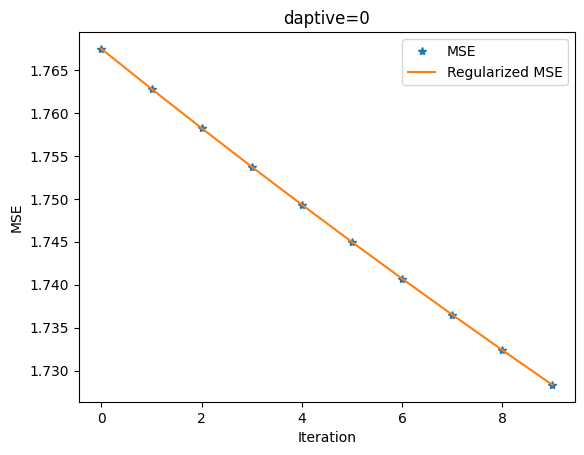

Training RMSE for fold 1: 1.3186234542816078
Test RMSE for fold 1: 1.3184235712808199
Training RMSE for Bias model on fold 1: 0.0
Test RMSE for Bias model on fold 1:        user   item  rating
0       177   3624     3.0
1       592    415     1.0
2       464   6934     4.0
3       603    541     3.0
4        28  61236     2.5
...     ...    ...     ...
20162   292   3386     2.0
20163   182   3019     3.5
20164   292   2005     3.0
20165   105   5995     4.0
20166   387  58293     2.0

[20167 rows x 3 columns]
Processing fold 2
mse : 1.7512247337684161
reg_mse : 1.7512247337684161
1
mse : 1.7464535272483641
reg_mse : 1.7464535272483641
2
mse : 1.7417622894387228
reg_mse : 1.7417622894387228
3
mse : 1.7371489665289703
reg_mse : 1.7371489665290158
4
mse : 1.7326115669411082
reg_mse : 1.73261156694129
5
mse : 1.728148159304395
reg_mse : 1.7281481593086419
6
mse : 1.72375687051153
reg_mse : 1.723756870538835
7
mse : 1.7194358838101664
reg_mse : 1.7194358838802892
8
mse : 1.7151834369733685

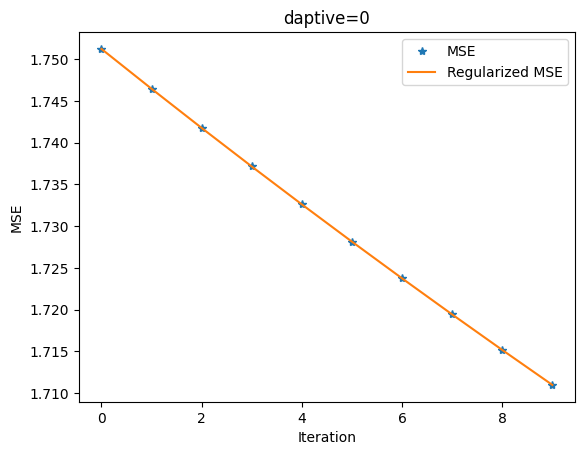

Training RMSE for fold 2: 1.3256989159807364
Test RMSE for fold 2: 1.319845326139525
Training RMSE for Bias model on fold 2: 0.0
Test RMSE for Bias model on fold 2:        user   item  rating
0       560   1682     4.0
1       274   1592     2.5
2       380   1676     5.0
3       579   3453     2.0
4       354   1639     4.0
...     ...    ...     ...
20162   480   2596     3.5
20163   514   1302     5.0
20164   474  55687     4.5
20165    96    193     1.0
20166   424   4262     3.5

[20167 rows x 3 columns]
Processing fold 3
mse : 1.7837086180041333
reg_mse : 1.7837086180041333
1
mse : 1.7787709857337297
reg_mse : 1.7787709857337297
2
mse : 1.7739066379423354
reg_mse : 1.7739066379423354
3
mse : 1.769113934793694
reg_mse : 1.769113934793694
4
mse : 1.764391281669873
reg_mse : 1.764391281669873
5
mse : 1.7597371277771952
reg_mse : 1.7597371277771952
6
mse : 1.755149964798065
reg_mse : 1.755149964798065
7
mse : 1.7506283255865664
reg_mse : 1.7506283255865664
8
mse : 1.7461707829066608


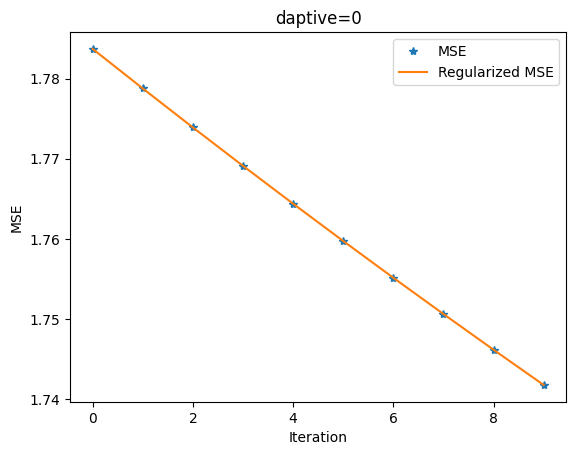

Training RMSE for fold 3: 1.3266593333446275
Test RMSE for fold 3: 1.319647206042431
Training RMSE for Bias model on fold 3: 0.0
Test RMSE for Bias model on fold 3:        user    item  rating
0        51    8874     5.0
1       288    2739     4.0
2       452    4718     5.0
3       590    6378     3.0
4       579    2485     3.0
...     ...     ...     ...
20162   177   64957     3.5
20163   156    2019     5.0
20164   352   49530     5.0
20165   464     527     4.5
20166    73  109374     5.0

[20167 rows x 3 columns]
Processing fold 4
mse : 1.8530503990284204
reg_mse : 1.8530503990284204
1
mse : 1.8471209678181988
reg_mse : 1.8471209678181988
2
mse : 1.8413027553001742
reg_mse : 1.8413027554368187
3
mse : 1.835592656837205
reg_mse : 1.8355926573588954
4
mse : 1.8299876687587247
reg_mse : 1.8299876699021118
5
mse : 1.8244848850928124
reg_mse : 1.8244848870889658
6
mse : 1.8190814941362294
reg_mse : 1.8190814972019287
7
mse : 1.8137747751697797
reg_mse : 1.8137747795106212
8
mse : 1.

In [26]:
# Set the number of folds
num_folds = 5

# Loop through the folds
for fold in range(num_folds):
    print(f'Processing fold {fold}')
    
    # Read the train and test sets for the current fold from CSV files
    train_df = pd.read_csv(f'{csvroot}/train_{fold}.csv')
    test_df = pd.read_csv(f'{csvroot}/test_{fold}.csv')
    
    # Convert the train and test sets to RDDs
    train_rdd = convert_DF_to_RDD(train_df)
    test_rdd = convert_DF_to_RDD(test_df)
    
    # Train the model on the current fold's training data
    P, Q = run_gd(RDD, M, N, K, MAXITER, GAMMA, LAMBDA, adaptive=0)
    
    # Evaluate the model on the current fold's training data
    train_rmse = evaluate_rmse(train_rdd, P, Q)
    print(f'Training RMSE for fold {fold}: {train_rmse}')
    
    # Evaluate the model on the current fold's test data
    test_rmse = evaluate_rmse(test_rdd, P, Q)
    print(f'Test RMSE for fold {fold}: {test_rmse}')
    
    # Train and evaluate the Bias model on the current fold's data
    train_bias, test_bias = train_and_evaluate_bias(train_df, test_df)
    print(f'Training RMSE for Bias model on fold {fold}: {train_bias}')
    print(f'Test RMSE for Bias model on fold {fold}: {test_bias}')
